In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/akkirr/Desktop/IT/annotated-diffusion


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

import torch
from torch import nan_to_num
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import requests

from datasets import load_dataset
from torchvision.utils import save_image
from torch.optim import Adam

In [182]:
from mylib import *
from lora import *

In [4]:
sampler = Sampler(linear_beta_schedule, 300)

In [5]:
# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Found cached dataset fashion_mnist (/Users/akkirr/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).filter(lambda x: x['label'] == 0).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

Filter:   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [8]:
results_folder = Path("./results_lora")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

# Lora

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [68]:
model1 = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model2 = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)

In [69]:
from copy import deepcopy
sd1 = deepcopy(model1.state_dict())
sd1['init_conv.weight'].sum()

tensor(2.6843)

In [70]:
nn.init.zeros_(model1.init_conv.weight)
sd2 = model1.state_dict()
sd1['init_conv.weight'].sum(), sd2['init_conv.weight'].sum()

(tensor(2.6843), tensor(0.))

In [75]:
class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.QKV = nn.Linear(1, 1)
        self.C = nn.Linear(1, 1)
        self.lrelu = nn.LeakyReLU()

    def forward(self, x):
        return self.C(self.lrelu(self.QKV(x)))


class TimeEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_proj = nn.Linear(1, 1)
        self.lrelu = nn.LeakyReLU()

    def forward(self, x):
        return self.lrelu(self.time_proj(x))


class LoraInjected(nn.Module):
    def __init__(self):
        super().__init__()
        self.src_linear = nn.Linear(1, 1)
        self.A = nn.Linear(1, 1)
        self.B = nn.Linear(1, 1)
        self.dropout = nn.Dropout1d()

    def forward(self, x):
        return self.src_linear(x) + self.dropout(self.B(self.A(x)))


class A(nn.Module):
    def __init__(self):
        super().__init__()
        self.just_linear = nn.Linear(1, 1)
        self.attn = Attention()
        self.time_embedder = TimeEmbedding()

    def forward(self, x):
        return self.attn(self.just_linear(x) + self.time_embedder(x))

In [167]:
from torch.optim import Adam
from copy import deepcopy

a = A()
optim = Adam(a.parameters())

In [168]:
sd1 = deepcopy(a.state_dict())
inp = torch.tensor([[1]], dtype=torch.float32)
a(inp)

tensor([[0.1108]], grad_fn=<AddmmBackward0>)

In [3]:
loss = a(inp).mean()
loss.backward()
optim.step()
optim.zero_grad()

sd2 = deepcopy(a.state_dict())
a(inp).mean()

NameError: name 'a' is not defined

In [ ]:
inject_lora(
        a,
        2, 0
        ["Attention"],
        [nn.Linear],
        [LoraInjectedLinear],
        verbose=True
    )

In [2]:
import torchvision
model = torchvision.models.resnet18()

inject_lora(
        a,
        2, 0,
        ["Attention"],
        [nn.Conv2d],
        [LoraInjectedConv2d],
        verbose=True
    )

NameError: name 'inject_lora' is not defined

In [177]:
sd1['attn.C.bias']

tensor([-0.0439])

In [178]:
sd2['attn.C.bias']

tensor([-0.0469])

In [172]:
sd2['attn.C.bias']

tensor([-0.0449])

In [43]:
def models_eq(model1, model2, keys):
    sd1 = model1.state_dict()
    sd2 = model2.state_dict()
    return all(torch.allclose(sd1[key], sd2[key]) for key in keys)

In [44]:
models_eq(model2, model1, model1.state_dict().keys())

False

In [45]:
model2.load_state_dict(model1.state_dict())
models_eq(model2, model1, model1.state_dict().keys())

True

In [ ]:
model1.load_state_dict

In [21]:
# model.load_state_dict(torch.load('checkpoints/1-not-trained.pt'))

<All keys matched successfully>

In [50]:
isinstance(nn.Linear(1, 1), tuple([nn.Linear]))

True

In [53]:
tmp = find_modules(model,
            ['LinearAttention'],
            [nn.Linear],
            [LoraInjectedLinear],
            )
list(tmp)

to_qkv False Conv2d
to_out False Sequential
0 False Conv2d
1 False GroupNorm
to_qkv False Conv2d
to_out False Sequential
0 False Conv2d
1 False GroupNorm
to_qkv False Conv2d
to_out False Sequential
0 False Conv2d
1 False GroupNorm
to_qkv False Conv2d
to_out False Sequential
0 False Conv2d
1 False GroupNorm
to_qkv False Conv2d
to_out False Sequential
0 False Conv2d
1 False GroupNorm
to_qkv False Conv2d
to_out False Sequential
0 False Conv2d
1 False GroupNorm


[]

In [41]:
for a, b in model.named_modules():
    print(a, b.__class__.__name__)

 Unet
init_conv Conv2d
time_mlp Sequential
time_mlp.0 SinusoidalPositionEmbeddings
time_mlp.1 Linear
time_mlp.2 GELU
time_mlp.3 Linear
downs ModuleList
downs.0 ModuleList
downs.0.0 ResnetBlock
downs.0.0.mlp Sequential
downs.0.0.mlp.0 SiLU
downs.0.0.mlp.1 Linear
downs.0.0.block1 Block
downs.0.0.block1.proj WeightStandardizedConv2d
downs.0.0.block1.norm GroupNorm
downs.0.0.block1.act SiLU
downs.0.0.block2 Block
downs.0.0.block2.proj WeightStandardizedConv2d
downs.0.0.block2.norm GroupNorm
downs.0.0.block2.act SiLU
downs.0.0.res_conv Identity
downs.0.1 ResnetBlock
downs.0.1.mlp Sequential
downs.0.1.mlp.0 SiLU
downs.0.1.mlp.1 Linear
downs.0.1.block1 Block
downs.0.1.block1.proj WeightStandardizedConv2d
downs.0.1.block1.norm GroupNorm
downs.0.1.block1.act SiLU
downs.0.1.block2 Block
downs.0.1.block2.proj WeightStandardizedConv2d
downs.0.1.block2.norm GroupNorm
downs.0.1.block2.act SiLU
downs.0.1.res_conv Identity
downs.0.2 Residual
downs.0.2.fn PreNorm
downs.0.2.fn.fn LinearAttention
downs.0

In [28]:
inject_lora(model, 1, 0.1, 
            ['LinearAttention'],
            [nn.Linear],
            [LoraInjectedLinear],
            verbose=True
            )

# Training

In [25]:
epochs = 6

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, sampler.timesteps, (batch_size,), device=device).long()

      loss = sampler.p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sampler.sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.431885689496994
Loss: 0.06605594605207443


# Sampling

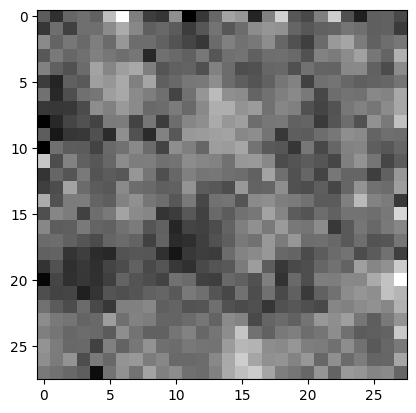

In [ ]:
# sample 64 images
samples = sampler.sample(model, image_size=image_size, batch_size=1, channels=channels)

# show a random one
random_index = 0
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

MovieWriter ffmpeg unavailable; using Pillow instead.


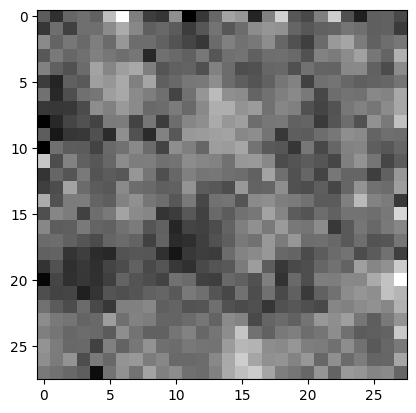

In [ ]:
import matplotlib.animation as animation

random_index = 0

fig = plt.figure()
ims = []
for i in range(sampler.timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()